In [1]:
import zipfile
import os

# ---- Get the uploaded file name ----
zip_filename ='/content/archive (1).zip'

# ---- Create a new folder to save extracted files ----
extract_folder = "my_dtrid_folder"
os.makedirs(extract_folder, exist_ok=True)

# ---- Unzip contents ----
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("✅ Folder unzipped successfully!")
print(f"📂 Extracted into: {extract_folder}")

# ---- Show extracted files ----
for root, dirs, files in os.walk(extract_folder):
    for file in files:
        print(os.path.join(root, file))

✅ Folder unzipped successfully!
📂 Extracted into: my_dtrid_folder
my_dtrid_folder/DRTiD/Original Images/0922_2.jpg
my_dtrid_folder/DRTiD/Original Images/0462_2.jpg
my_dtrid_folder/DRTiD/Original Images/0555_1.jpg
my_dtrid_folder/DRTiD/Original Images/0038_2.jpg
my_dtrid_folder/DRTiD/Original Images/0919_1.jpg
my_dtrid_folder/DRTiD/Original Images/1085_2.jpg
my_dtrid_folder/DRTiD/Original Images/0632_2.jpg
my_dtrid_folder/DRTiD/Original Images/1873_2.jpg
my_dtrid_folder/DRTiD/Original Images/0944_2.jpg
my_dtrid_folder/DRTiD/Original Images/0734_1.jpg
my_dtrid_folder/DRTiD/Original Images/0223_1.jpg
my_dtrid_folder/DRTiD/Original Images/1229_2.jpg
my_dtrid_folder/DRTiD/Original Images/1871_2.jpg
my_dtrid_folder/DRTiD/Original Images/0292_2.jpg
my_dtrid_folder/DRTiD/Original Images/0360_2.jpg
my_dtrid_folder/DRTiD/Original Images/0387_2.jpg
my_dtrid_folder/DRTiD/Original Images/0524_1.jpg
my_dtrid_folder/DRTiD/Original Images/1669_2.jpg
my_dtrid_folder/DRTiD/Original Images/0332_2.jpg
my_

In [19]:
import numpy as np
import pandas as pd
import os, gc
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras import layers, models

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


In [20]:
IMG_DIR = "/content/my_dtrid_folder/DRTiD/Original Images"
TRAIN_CSV = "/content/my_dtrid_folder/DRTiD/Ground Truths/DR_grade/a. DR_grade_Training.csv"
TEST_CSV  = "/content/my_dtrid_folder/DRTiD/Ground Truths/DR_grade/b. DR_grade_Testing.csv"

IMG_SIZE = (300, 300)
BATCH_SIZE = 16
SEED = 42


**LOAD CSVs & EXPAND (Macula + Optic as separate images)**

In [21]:
train_raw = pd.read_csv(TRAIN_CSV)
test_raw  = pd.read_csv(TEST_CSV)

def expand_df(df):
    mac = pd.DataFrame({
        "filename": df["Macula"].astype(str) + ".jpg",
        "label": (df["Grade"] > 0).astype(int)
    })

    optic = pd.DataFrame({
        "filename": df["Optic disc"].astype(str) + ".jpg",
        "label": (df["Grade"] > 0).astype(int)
    })

    return pd.concat([mac, optic], ignore_index=True)

train_df = expand_df(train_raw)
test_df  = expand_df(test_raw)

print("Training images after expand:", len(train_df))
print("Testing images after expand:", len(test_df))
train_df.head()


Training images after expand: 2000
Testing images after expand: 1100


,filename,label
0,0002_1.jpg,0
1,0003_1.jpg,1
2,0004_1.jpg,1
3,0005_1.jpg,1
4,0006_1.jpg,1


**EDA**

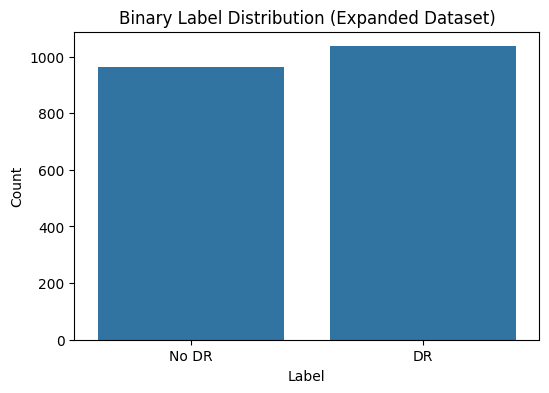

Counts:
 label
1    1036
0     964
Name: count, dtype: int64


/tmp/ipython-input-1452142457.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_raw["Grade"], palette="viridis")


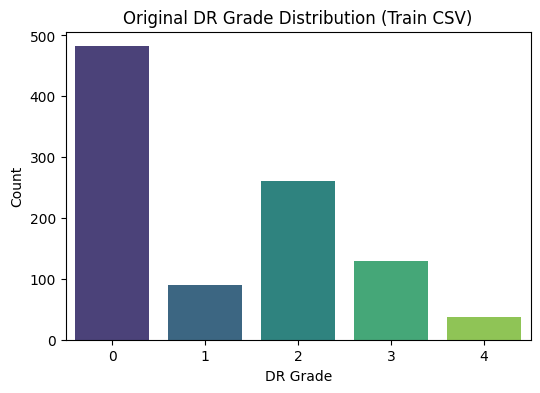

Grade Counts:
 Grade
0    482
2    260
3    130
1     90
4     38
Name: count, dtype: int64


/tmp/ipython-input-1452142457.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Macula", "Optic"], y=[mac_count, optic_count], palette="coolwarm")


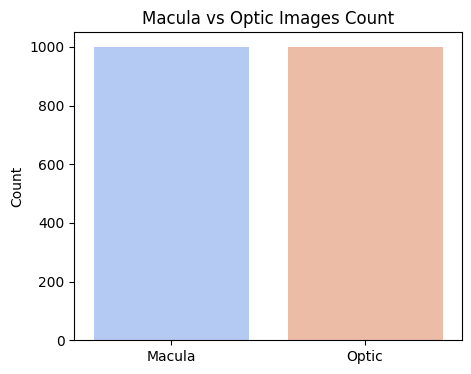

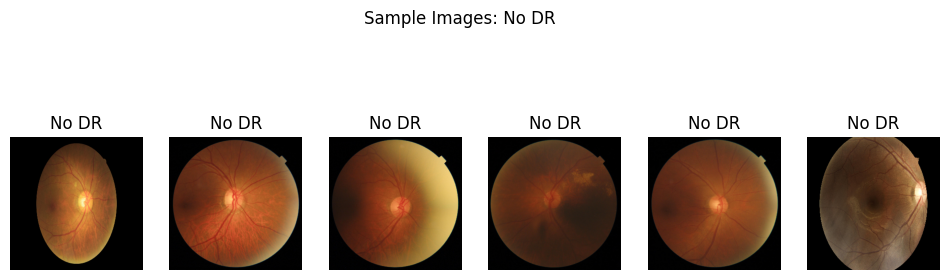

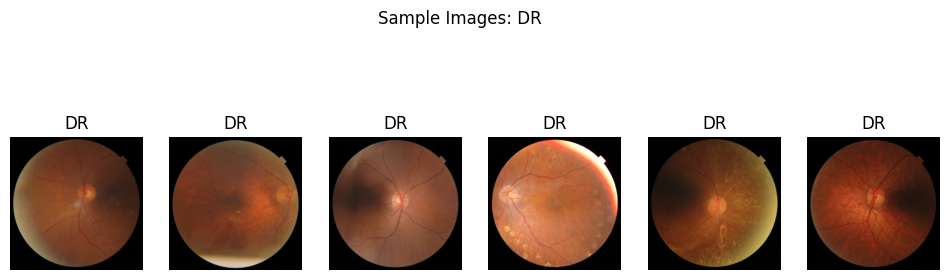

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x=train_df["label"])
plt.xticks([0, 1], ["No DR", "DR"])
plt.title("Binary Label Distribution (Expanded Dataset)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

print("Counts:\n", train_df["label"].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(x=train_raw["Grade"], palette="viridis")
plt.title("Original DR Grade Distribution (Train CSV)")
plt.xlabel("DR Grade")
plt.ylabel("Count")
plt.show()

print("Grade Counts:\n", train_raw["Grade"].value_counts())
mac_count = len(train_raw)
optic_count = len(train_raw)

plt.figure(figsize=(5,4))
sns.barplot(x=["Macula", "Optic"], y=[mac_count, optic_count], palette="coolwarm")
plt.title("Macula vs Optic Images Count")
plt.ylabel("Count")
plt.show()
import tensorflow as tf
import os

IMG_SIZE = (300, 300)   # or (299, 299) for Xception
img_dir = IMG_DIR
RANDOM_STATE = 42

def show_samples(df, label, n=6):
    subset = df[df["label"] == label].sample(
        min(n, len(df[df["label"] == label])),
        random_state=RANDOM_STATE
    )

    plt.figure(figsize=(12,4))
    for i, (_, row) in enumerate(subset.iterrows()):
        img_path = os.path.join(img_dir, row["filename"])
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("No DR" if label == 0 else "DR")

    plt.suptitle(f"Sample Images: {'No DR' if label == 0 else 'DR'}")
    plt.show()

show_samples(train_df, 0)   # No DR samples
show_samples(train_df, 1)   # DR samples


**CLASS BALANCE & CLASS WEIGHTS**

In [23]:
cw = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=train_df["label"].values
)

class_weights = {0: cw[0], 1: cw[1]}
class_weights


{0: np.float64(1.037344398340249), 1: np.float64(0.9652509652509652)}

**PREPROCESSING: CLAHE**

In [24]:
def clahe_preprocess(img):
    img = img.astype(np.uint8)

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    cl = clahe.apply(l)

    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB).astype(np.float32)

    img = eff_preprocess(img)
    return img


**IMAGE GENERATORS**

In [25]:
train_gen = ImageDataGenerator(
    preprocessing_function=clahe_preprocess,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

val_gen = ImageDataGenerator(
    preprocessing_function=clahe_preprocess,
    validation_split=0.2
)

test_gen = ImageDataGenerator(
    preprocessing_function=clahe_preprocess
)

train_flow = train_gen.flow_from_dataframe(
    train_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="raw",
    batch_size=BATCH_SIZE,
    subset="training",
    seed=SEED
)

val_flow = val_gen.flow_from_dataframe(
    train_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="raw",
    batch_size=BATCH_SIZE,
    subset="validation",
    shuffle=False
)

test_flow = test_gen.flow_from_dataframe(
    test_df,
    directory=IMG_DIR,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="raw",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 1600 validated image filenames.
Found 400 validated image filenames.
Found 1100 validated image filenames.


**Build EfficientNetB3 Model**

In [26]:
tf.keras.backend.clear_session()
gc.collect()

base = EfficientNetB3(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)
base.trainable = False  # Freeze stage 1

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, output)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,636,272 (44.39 MB)

 Trainable params: 852,737 (3.25 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

**Training Stage 1 (Frozen EfficientNetB3)**

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

cb1 = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
]

history1 = model.fit(
    train_flow,
    epochs=15,
    validation_data=val_flow,
    class_weight=class_weights,
    callbacks=cb1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 821ms/step - accuracy: 0.5316 - loss: 0.7179 - val_accuracy: 0.7025 - val_loss: 0.6271 - learning_rate: 1.0000e-04
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 703ms/step - accuracy: 0.6208 - loss: 0.6588 - val_accuracy: 0.6200 - val_loss: 0.6466 - learning_rate: 1.0000e-04
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 690ms/step - accuracy: 0.6110 - loss: 0.6451 - val_accuracy: 0.6950 - val_loss: 0.5897 - learning_rate: 1.0000e-04
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 698ms/step - accuracy: 0.6562 - loss: 0.6202 - val_accuracy: 0.6975 - val_loss: 0.5743 - learning_rate: 1.0000e-04
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 683ms/step - accuracy: 0.6410 - loss: 0.6334 - val_accuracy: 0.7100 - val_loss: 0.5639 - learning_rate: 1.0000e-04
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 690ms/step - accuracy: 0.6604 - loss: 0.6122 - val_accuracy: 0.7075 - val_loss: 0.5659 - learning_rate: 1.0000e-04
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 6

**Fine-Tuning Stage 2**

In [28]:
base.trainable = True
for layer in base.layers[:-60]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

cb2 = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
    tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
]

history2 = model.fit(
    train_flow,
    epochs=40,
    validation_data=val_flow,
    class_weight=class_weights,
    callbacks=cb2
)


Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 132s 809ms/step - accuracy: 0.6419 - loss: 0.6316 - val_accuracy: 0.7325 - val_loss: 0.5397 - learning_rate: 1.0000e-05
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 674ms/step - accuracy: 0.6515 - loss: 0.6136 - val_accuracy: 0.7300 - val_loss: 0.5395 - learning_rate: 1.0000e-05
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 689ms/step - accuracy: 0.6846 - loss: 0.5816 - val_accuracy: 0.7275 - val_loss: 0.5384 - learning_rate: 1.0000e-05
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 688ms/step - accuracy: 0.6862 - loss: 0.5759 - val_accuracy: 0.7425 - val_loss: 0.5274 - learning_rate: 1.0000e-05
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 688ms/step - accuracy: 0.6985 - loss: 0.5723 - val_accuracy: 0.7400 - val_loss: 0.5236 - learning_rate: 1.0000e-05
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 689ms/step - accuracy: 0.7260 - loss: 0.5331 - val_accuracy: 0.7450 - val_loss: 0.5170 - learning_rate: 1.0000e-05
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 6

**Testing**

69/69 ━━━━━━━━━━━━━━━━━━━━ 54s 625ms/step
🔥 Test Accuracy: 0.7336363636363636

Classification Report:
              precision    recall  f1-score   support

           0     0.6657    0.8981    0.7647       530
           1     0.8597    0.5807    0.6932       570

    accuracy                         0.7336      1100
   macro avg     0.7627    0.7394    0.7289      1100
weighted avg     0.7663    0.7336    0.7276      1100



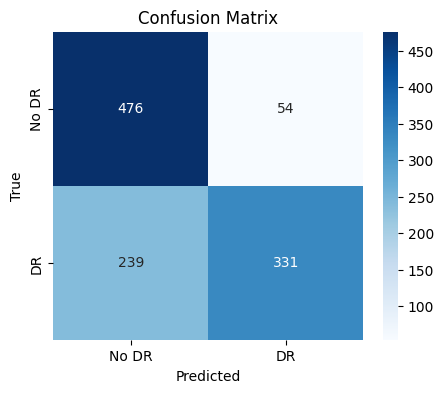

In [29]:
y_true = test_flow.labels
y_prob = model.predict(test_flow).ravel()
y_pred = (y_prob >= 0.5).astype(int)

acc = (y_true == y_pred).mean()
print("🔥 Test Accuracy:", acc)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No DR", "DR"],
    yticklabels=["No DR", "DR"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


**TRAINING HISTORY PLOTTER (Accuracy + Loss)**

In [38]:

def plot_training_history(history, model_name="Model"):
     for any Keras model (EfficientNetB3, Xception, CNN, etc.)


    acc = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])
    loss = history.history.get("loss", [])
    val_loss = history.history.get("val_loss", [])

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # -------- Accuracy Plot --------
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Val Accuracy")
    plt.title(f"{model_name} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # -------- Loss Plot --------
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.show()


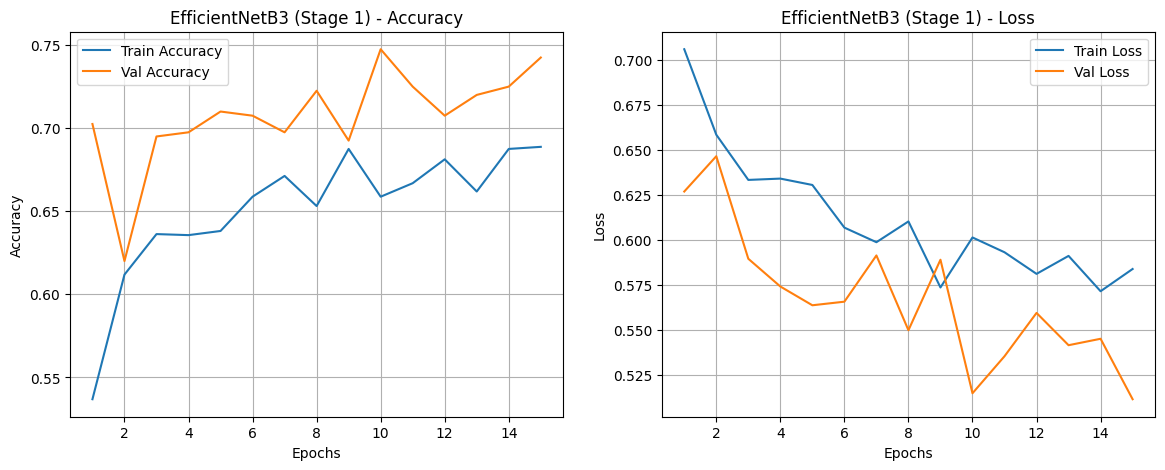

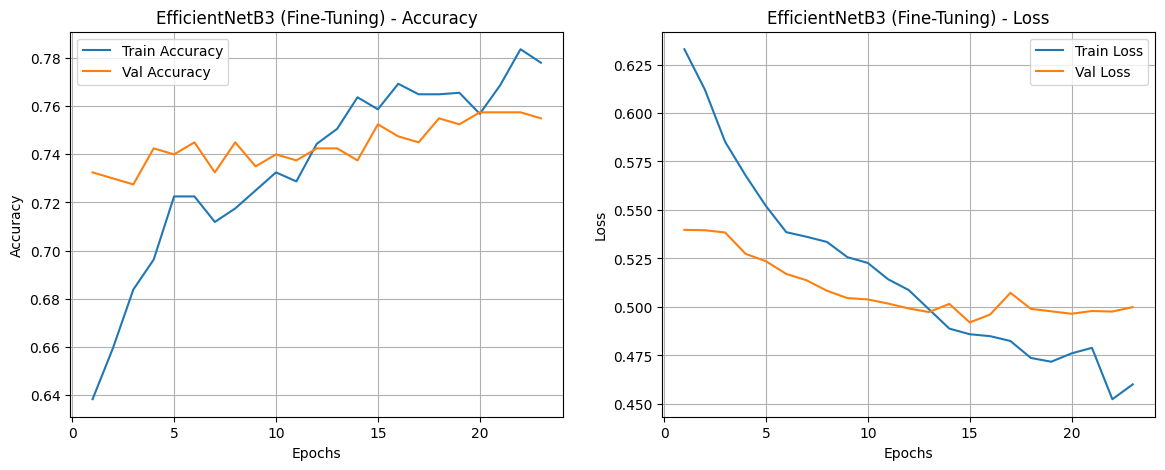

In [39]:
plot_training_history(history1, "EfficientNetB3 (Stage 1)")
plot_training_history(history2, "EfficientNetB3 (Fine-Tuning)")


In [30]:

model.save("/content/efficientnetb3_dr_model.h5")
print("Model saved successfully!")


Model saved successfully!


In [31]:

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

loaded_model = load_model(
    "/content/efficientnetb3_dr_model.h5",
    compile=False
)

print("Model loaded successfully!")


Model loaded successfully!


**Testing the Model**

In [32]:
import cv2
import numpy as np

IMG_SIZE = (300, 300)

def preprocess_input_image(img_path):
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found: " + img_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)

    # CLAHE
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    cl = clahe.apply(l)

    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB).astype(np.float32)

    # EfficientNetB3 preprocess (-1 to +1)
    img = eff_preprocess(img)

    # Add batch dimension
    img = np.expand_dims(img, axis=0)
    return img


In [33]:
def predict_dr(img_path):
    # Preprocess
    img = preprocess_input_image(img_path)

    # Prediction
    prob = loaded_model.predict(img)[0][0]
    label = "DR" if prob >= 0.5 else "No DR"

    print("===================================")
    print(f"Image: {img_path}")
    print(f"Prediction: {label}")
    print(f"Probability (DR): {prob:.4f}")
    print("===================================")

    return label, prob


In [37]:
img_path = "/content/my_dtrid_folder/DRTiD/Original Images/0009_1.jpg"
predict_dr(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Image: /content/my_dtrid_folder/DRTiD/Original Images/0009_1.jpg
Prediction: No DR
Probability (DR): 0.1808


('No DR', np.float32(0.18077241))